In [5]:
import os

from IPython.display import clear_output

import numpy as np
import tensorflow as tf

# Graphics and plotting.
import mediapy as media
import matplotlib.pyplot as plt
# Configure MuJoCo to use the EGL rendering backend (requires GPU)
#os.environ['MUJOCO_GL'] = "egl"
os.environ['MUJOCO_GL'] = "glfw" #for mac
try:
  import mujoco
except Exception as e:
  raise e from RuntimeError("Something went wrong during import")
# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

2024-03-02 10:20:52.589571: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


""

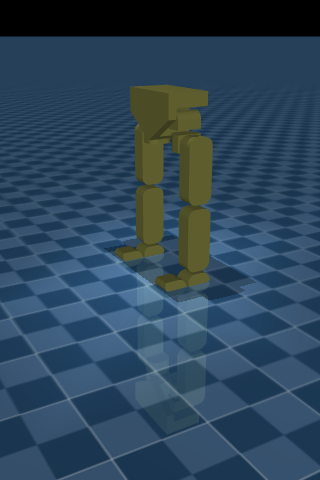

In [6]:
model = mujoco.MjModel.from_xml_path('bipede.xml')
data = mujoco.MjData(model)

ctx = mujoco.GLContext(1000, 1000)
ctx.make_current()

renderer = mujoco.Renderer(model, 480,)

mujoco.mj_forward(model, data)
renderer.update_scene(data)

media.show_image(renderer.render())

In [7]:
class RBuffer():
    def __init__(self, maxsize, statedim, naction):
        self.cnt = 0
        self.maxsize = maxsize
        self.state_memory = np.zeros((self.maxsize, *statedim))
        self.next_state_memory = np.zeros((self.maxsize, *statedim))
        self.action_memory = np.zeros((self.maxsize, naction))
        self.reward_memory = np.zeros(self.maxsize)
        self.done_memory = np.zeros(self.maxsize, dtype=bool)

    def storexp(self, state, action, reward, done, next_state):
        index = self.cnt % self.maxsize

        self.state_memory[index] = state
        self.next_state_memory[index] = next_state
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.done_memory[index] = done

        self.cnt += 1

    def sample(self, batch_size):
        currentmaxSize = min(self.cnt, self.maxsize)

        batch = np.random.choice(currentmaxSize, batch_size, replace=False)

        states = self.state_memory[batch]
        next_states = self.next_state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        dones = self.done_memory[batch]
        return states, actions, rewards, dones, next_states

class Actor(tf.keras.Model):
    def __init__(self, stateDim, actionDim, layer1Dim=512, layer2Dim=512):
        super().__init__()
        self.stateDim = stateDim
        self.actionDim = actionDim
        self.layer1Dim = layer1Dim
        self.layer2Dim = layer2Dim
        self.createModel()

    def createModel(self):
        "creates a tensorflow model of 2 leaky-relu layers followed by a custom piece-wise linear tanh output layer"
        self.l1 = tf.keras.layers.Dense(
            input_shape=self.stateDim, units=self.layer1Dim, activation=tf.keras.layers.LeakyReLU(
                alpha=0.01),
            kernel_regularizer=tf.keras.regularizers.l2(0.01), bias_regularizer=tf.keras.regularizers.l2(0.01))
        self.l2 = tf.keras.layers.Dense(
            units=self.layer2Dim, activation=tf.keras.layers.LeakyReLU(
                alpha=0.01),
            kernel_regularizer=tf.keras.regularizers.l2(0.01), bias_regularizer=tf.keras.regularizers.l2(0.01))
        self.lact = tf.keras.layers.Dense(units= self.actionDim, activation= self.custom_tanh)

    def custom_tanh(self, x):
        y1 = 30 * tf.keras.activations.tanh(x[:, 0:1])
        y2 = 30 * tf.keras.activations.tanh(x[:, 1:2])
        y3 = 90 * tf.keras.activations.tanh(x[:, 2:3])
        y4 = 45 * tf.keras.activations.tanh(x[:, 3:4]) + 45
        y5 = 30 * tf.keras.activations.tanh(x[:, 4:5])
        y6 = 30 * tf.keras.activations.tanh(x[:, 5:6])
        
        y7 = 30 * tf.keras.activations.tanh(x[:, 6:7])
        y8 = 30 * tf.keras.activations.tanh(x[:, 7:8]) 
        y9 = 90 * tf.keras.activations.tanh(x[:, 8:9])
        y10 = 45 * tf.keras.activations.tanh(x[:, 9:10]) + 45
        y11 = 30 * tf.keras.activations.tanh(x[:, 10:11])
        y12 = 30 * tf.keras.activations.tanh(x[:, 11:12])

        return tf.concat([y1, y2, y3, y4, y5, y6, y7, y8, y9, y10, y11, y12], axis=1)

    def call(self, state):
        x = self.l1(state)
        x = self.l2(x)
        x = self.lact(x)
        return x

    def save_model(self):
        print("\n saving actor model ...")
        self.save("networks/actor")

class Critic(tf.keras.Model):
    def __init__(self, stateDim, layer1Dim=512, layer2Dim=512):
        super().__init__()
        self.stateDim = stateDim
        self.layer1Dim = layer1Dim
        self.layer2Dim = layer2Dim
        self.createModel()


    def createModel(self):
        "creates a tensorflow model of 2 leaky relu layers followed by a linear output"
        self.l1 = tf.keras.layers.Dense(
            input_shape=self.stateDim, units=self.layer1Dim, activation=tf.keras.layers.LeakyReLU(
                alpha=0.01),
            kernel_regularizer=tf.keras.regularizers.l2(0.01), bias_regularizer=tf.keras.regularizers.l2(0.01))
        self.l2 = tf.keras.layers.Dense(
            units=self.layer2Dim, activation=tf.keras.layers.LeakyReLU(
                alpha=0.01),
            kernel_regularizer=tf.keras.regularizers.l2(0.01), bias_regularizer=tf.keras.regularizers.l2(0.01))
        self.lq = tf.keras.layers.Dense(1, activation=None)

    def call(self, state, action):
        x = self.l1(tf.concat([state, action], axis=1))
        x = self.l2(x)
        x = self.lq(x)
        return x

    def save_model(self):
        print("saving critic model ...")
        self.save("networks/critic")



class Agent():
    def __init__(self, num_actions, num_states) -> None:
        self.actionDim = num_actions
        self.stateDim = (num_states,)
        self.actorMain = Actor(
            self.stateDim, self.actionDim, layer1Dim = 1000, layer2Dim = 1000)
        self.actorTarget = Actor(
            self.stateDim, self.actionDim, layer1Dim = 1000, layer2Dim = 1000)
        self.criticMain = Critic(self.stateDim, layer1Dim = 1000, layer2Dim = 1000)
        self.criticTarget = Critic(self.stateDim, layer1Dim = 1000, layer2Dim = 1000)

        self.actorOptimizer = tf.keras.optimizers.Adam(learning_rate=1e-5) #1e-5
        self.criticOptimizer = tf.keras.optimizers.Adam(learning_rate=5e-4) #5e-4

        self.gamma = 0.985   #0.975
        self.tau = 0.0005   #0.0005

        self.batchSize = 256
        self.maxBufferSize = 1000000

        self.replayBuffer = RBuffer(maxsize=self.maxBufferSize,
                                    statedim=self.actorMain.stateDim,
                                    naction=self.actorMain.actionDim)

        self.actorTarget.compile(optimizer=self.actorOptimizer)
        self.criticTarget.compile(optimizer=self.criticOptimizer)
        self.actorMain.compile(optimizer=self.actorOptimizer)
        self.criticMain.compile(optimizer=self.criticOptimizer)

        self.updateActorTarget(1)
        self.updateCriticTarget(1)


    def act(self, state):
        if self.replayBuffer.cnt < self.batchSize:
            actions = tf.random.normal(
                shape=(1, self.actionDim), mean=0.0, stddev=10.0)

        else:
            actions = self.actorMain(state)
            actions += tf.random.normal(shape=[self.actionDim],
                                        mean=0.0, stddev=2)
        return actions

    def updateActorTarget(self, tau):
        weights = []
        target_weights = self.actorTarget.trainable_variables
        for i, weight in enumerate(self.actorMain.trainable_variables):
            weights.append(tau * weight + (1-tau)
                           * target_weights[i])
            target_weights[i].assign(weights[i])

    def updateCriticTarget(self, tau):
        weights = []
        target_weights = self.criticTarget.trainable_variables
        for i, weight in enumerate(self.criticMain.trainable_variables):
            weights.append(tau * weight + (1-tau)
                           * target_weights[i])
            target_weights[i].assign(weights[i])

    def train(self):
        if self.replayBuffer.cnt < self.batchSize:
            return

        states, actions, rewards, dones, nextStates = self.replayBuffer.sample(
            self.batchSize)

        states = tf.convert_to_tensor(states, dtype=tf.float32)
        nextStates = tf.convert_to_tensor(nextStates, dtype=tf.float32)
        rewards = tf.convert_to_tensor(rewards, dtype=tf.float32)
        actions = tf.convert_to_tensor(actions, dtype=tf.float32)
        dones = tf.convert_to_tensor(dones, dtype=tf.float32)

        actions = tf.reshape(actions, (self.batchSize, self.actionDim))

        self.train_backprop(states, actions, rewards, dones, nextStates)

        self.updateActorTarget(self.tau)
        self.updateCriticTarget(self.tau)

    @tf.function
    def train_backprop(self, states, actions, rewards, dones, nextStates):
        with tf.GradientTape() as tape1:
            actionNext = self.actorTarget(nextStates)
            qNext = tf.squeeze(self.criticTarget(nextStates, actionNext))
            qCritic = tf.squeeze(self.criticMain(states, actions), 1)
            qBellman = rewards + self.gamma * qNext * (1-dones)
            criticLoss = tf.keras.losses.MSE(qCritic, qBellman)

        with tf.GradientTape() as tape2:
            newAction = self.actorMain(states)
            Q = self.criticMain(states, newAction)
            actorLoss = tf.reduce_mean(-Q)

        gradsCritic = tape1.gradient(
            criticLoss, self.criticMain.trainable_variables)
        self.criticOptimizer.apply_gradients(
            zip(gradsCritic, self.criticMain.trainable_variables))

        gradsActor = tape2.gradient(
            actorLoss, self.actorMain.trainable_variables)
        self.actorOptimizer.apply_gradients(
            zip(gradsActor, self.actorMain.trainable_variables))

In [42]:
class Controller():
    def __init__(self):
        self.integral = 0

    def get_motor_cmd(self, data, ref_pos):
        state = 180*data.qpos[7:]/np.pi
        vel = data.qvel[6:]
        erreur = state - ref_pos
        self.integral = np.clip(self.integral + erreur, -100, 100)
        cmd = np.clip(-17*erreur - 2*vel - 0.1*self.integral, -100, 100)
        return cmd
    
    def reset(self):
        self.integral = 0


def plot(reward_history, average_reward, agent, model, data, duration = 5, fps = 25):
    clear_output(wait=True)

    # Simulate and display video.
    frames = []
    mujoco.mj_resetData(model, data)  # Reset state and time.
    mujoco.mj_forward(model, data)
    hip_z, hip_y, _ = get_hip_info(data)
    controller = Controller()
    while data.time < duration and hip_y < 1 and hip_z > 0.4 and hip_z < 1.5:
      observation = np.concatenate([data.qpos, data.qvel], axis=0)
      action = agent.act(np.array([observation]))
      data.ctrl = controller.get_motor_cmd(data, action)
      mujoco.mj_step(model, data)
      if len(frames) < data.time * fps:
        renderer.update_scene(data)
        pixels = renderer.render()
        frames.append(pixels)
      hip_z, hip_y, _ = get_hip_info(data)
    media.show_video(frames, fps= fps)
    plt.plot(reward_history)
    plt.plot(average_reward)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.ylim([np.min(reward_history), np.max(reward_history)])
    plt.show()

def get_hip_info(data):
    hip_z = data.geom_xpos[1][2].copy()
    hip_y = data.geom_xpos[1][1].copy()
    hip_y_vel = data.cvel[1][4].copy()
    return hip_z, hip_y, hip_y_vel

def get_reward(model, data, ref_pos):
    hip_z, hip_y, hip_y_vel = get_hip_info(data)
    hip_z_initial = model.geom_pos[1][2]
    state = 180*data.qpos[7:]/np.pi
    reward = - 10*hip_y -10*(hip_z - hip_z_initial)**2 - 1e-4*np.sum(np.square(ref_pos - state))
    return reward

def take_step_and_train(agent, controller, model, data):
    observation = np.concatenate([data.qpos, data.qvel], axis=0)
    action = agent.act(np.array([observation]))
    ref_pos = action.numpy()[0]
    data.ctrl = controller.get_motor_cmd(data, ref_pos)
    mujoco.mj_step(model, data)
    reward = get_reward(model, data, ref_pos)
    nextObservation = np.concatenate([data.qpos, data.qvel], axis=0)
    hip_z, hip_y, _ = get_hip_info(data)
    if hip_y < 1 and hip_z > 0.4 and hip_z < 1.5:
        done = 0
    elif data.time > 5:
        done = 1
    else:
        done = 1
        reward = -100
    agent.replayBuffer.storexp(
        observation, action, reward, done, nextObservation)
    agent.train()
    observation = nextObservation
    return reward, done

def ddpg_train(agent, data, iter):
    reward_history = []
    mujoco.mj_resetData(model, data)
    mujoco.mj_forward(model, data)
    reward_history = []
    average_reward = []
    controller = Controller()
    for i in range(iter):
        done = 0
        R = 0
        integral = 0
        mujoco.mj_resetData(model, data)
        mujoco.mj_forward(model, data)
        controller.reset()
        while done == 0:
            reward, done= take_step_and_train(agent, controller, model, data)
            R+= reward
        reward_history.append(R)
        if len(reward_history) > 20:
            average_reward.append(reward_history[-20:]/20)
        if i%20==19:
            plot(reward_history, average_reward, agent, model, data)
            agent.actorMain.save_model()
            agent.criticMain.save_model()
        _, hip_y, _ = get_hip_info(data)
        print(f"episode {i}: the robot walked {np.round(-hip_y, 2)}m")

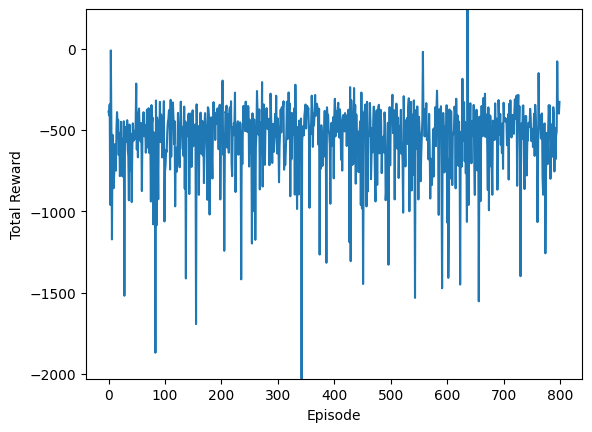


 saving actor model ...
INFO:tensorflow:Assets written to: networks/actor/assets


INFO:tensorflow:Assets written to: networks/actor/assets


saving critic model ...
INFO:tensorflow:Assets written to: networks/critic/assets


INFO:tensorflow:Assets written to: networks/critic/assets


episode 799: the robot walked -0.28m
episode 800: the robot walked 0.07m
episode 801: the robot walked -0.28m
episode 802: the robot walked 0.04m
episode 803: the robot walked -0.16m
episode 804: the robot walked 0.04m
episode 805: the robot walked -0.23m
episode 806: the robot walked 0.14m
episode 807: the robot walked -0.38m
episode 808: the robot walked 0.14m
episode 809: the robot walked -0.41m
episode 810: the robot walked 0.1m
episode 811: the robot walked 0.17m
episode 812: the robot walked -0.15m
episode 813: the robot walked 0.11m


In [43]:
bipede = Agent(12, 37)
ddpg_train(bipede, data, 4000)